In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mini_torch import Tensor, nn, optim, F, schedulers

## Create Synthetic Text Dataset

We'll create a simple synthetic dataset for sentiment classification.

In [2]:
# Create a simple synthetic text classification dataset
np.random.seed(42)

# Parameters
vocab_size = 1000  # Vocabulary size
max_seq_len = 50   # Maximum sequence length
embed_dim = 64     # Embedding dimension
n_classes = 2      # Binary classification (positive/negative sentiment)

# Generate synthetic data
# Positive samples: contain more tokens from upper half of vocabulary
# Negative samples: contain more tokens from lower half of vocabulary

def generate_sequence(is_positive, seq_len=50):
    """Generate a synthetic sequence"""
    if is_positive:
        # Positive: more tokens from upper half (500-1000)
        tokens = np.random.choice(range(500, vocab_size), size=int(seq_len * 0.7))
        noise = np.random.choice(range(vocab_size), size=int(seq_len * 0.3))
    else:
        # Negative: more tokens from lower half (0-500)
        tokens = np.random.choice(range(0, 500), size=int(seq_len * 0.7))
        noise = np.random.choice(range(vocab_size), size=int(seq_len * 0.3))
    
    seq = np.concatenate([tokens, noise])
    np.random.shuffle(seq)
    return seq[:seq_len]

# Generate training data (2000 samples)
n_train = 2000
X_train = []
y_train = []

for i in range(n_train // 2):
    # Positive samples
    X_train.append(generate_sequence(is_positive=True, seq_len=max_seq_len))
    y_train.append(1)
    
    # Negative samples
    X_train.append(generate_sequence(is_positive=False, seq_len=max_seq_len))
    y_train.append(0)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Generate test data (500 samples)
n_test = 500
X_test = []
y_test = []

for i in range(n_test // 2):
    X_test.append(generate_sequence(is_positive=True, seq_len=max_seq_len))
    y_test.append(1)
    X_test.append(generate_sequence(is_positive=False, seq_len=max_seq_len))
    y_test.append(0)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Shuffle
train_idx = np.random.permutation(len(X_train))
X_train = X_train[train_idx]
y_train = y_train[train_idx]

test_idx = np.random.permutation(len(X_test))
X_test = X_test[test_idx]
y_test = y_test[test_idx]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Max sequence length: {max_seq_len}")
print(f"\nSample sequence (first 10 tokens): {X_train[0][:10]}")
print(f"Sample label: {y_train[0]} ({'Positive' if y_train[0] == 1 else 'Negative'})")

Training set: (2000, 50)
Test set: (500, 50)
Vocabulary size: 1000
Max sequence length: 50

Sample sequence (first 10 tokens): [628 931 736 873 537 517 924 719 884 345]
Sample label: 1 (Positive)


## Define Attention-Based Classification Model

In [3]:
class AttentionClassifier(nn.Module):
    """
    Attention-based sequence classifier with proper Q, K, V matrices.
    
    Architecture:
    1. Embedding layer
    2. Positional encoding
    3. Multi-head attention layers (with Q, K, V projections)
    4. Feed-forward network
    5. Global pooling and classification
    """
    
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, 
                 max_seq_len, num_classes, dropout=0.1):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        
        # Embedding layer (fixed - not trained to reduce parameters)
        self.embedding = Tensor(np.random.randn(vocab_size, embed_dim).astype(np.float32) * 0.01, requires_grad=False)
        
        # Positional encoding (learnable)
        self.pos_encoding = Tensor(np.random.randn(max_seq_len, embed_dim).astype(np.float32) * 0.01)
        
        # Transformer blocks with proper attention mechanism
        self.transformer_blocks = []
        for _ in range(num_layers):
            block = nn.TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=embed_dim * 4,
                dropout=dropout
            )
            self.transformer_blocks.append(block)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.Linear(embed_dim // 2, num_classes)
        )
        
        # Collect parameters
        self._parameters = [self.pos_encoding]
        for block in self.transformer_blocks:
            self._parameters.extend(block.parameters())
        self._parameters.extend(self.classifier.parameters())
    
    def forward(self, x):
        """
        Forward pass with multi-head attention.
        
        Args:
            x: Input tensor of token indices, shape (batch_size, seq_len)
        
        Returns:
            Logits of shape (batch_size, num_classes)
        """
        batch_size, seq_len = x.shape
        
        # Embedding lookup: (batch, seq_len) -> (batch, seq_len, embed_dim)
        embedded = []
        for b in range(batch_size):
            seq_emb = []
            for t in range(seq_len):
                token_idx = int(x.data[b, t])
                seq_emb.append(self.embedding.data[token_idx])
            embedded.append(np.stack(seq_emb))
        embedded_data = np.stack(embedded)  # (batch, seq_len, embed_dim)
        
        # Add positional encoding (broadcast over batch)
        pos_data = self.pos_encoding.data[:seq_len].reshape(1, seq_len, -1)
        x_data = embedded_data + pos_data
        
        # Create tensor for forward pass
        x = Tensor(x_data)
        
        # Pass through transformer blocks (with Q, K, V attention)
        for block in self.transformer_blocks:
            x = block(x)
        
        # Global average pooling over sequence dimension
        x = x.mean(axis=1)  # (batch, embed_dim)
        
        # Classification
        logits = self.classifier(x)
        
        return logits

# Create model with proper attention mechanism
print("Creating Attention-based Classifier with Q, K, V matrices...")
model = AttentionClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=4,
    num_layers=2,
    max_seq_len=max_seq_len,
    num_classes=n_classes,
    dropout=0.1
)

print(f"Model created with {len(model.parameters())} parameter tensors")
print(f"Embedding dimension: {embed_dim}")
print(f"Number of attention heads: 4")
print(f"Number of transformer layers: 2")
print(f"\nEach transformer block contains:")
print(f"  - Multi-Head Attention with Q, K, V projections")
print(f"  - Feed-forward network")
print(f"  - Layer normalization")
print(f"  - Residual connections")

Creating Attention-based Classifier with Q, K, V matrices...
Model created with 37 parameter tensors
Embedding dimension: 64
Number of attention heads: 4
Number of transformer layers: 2

Each transformer block contains:
  - Multi-Head Attention with Q, K, V projections
  - Feed-forward network
  - Layer normalization
  - Residual connections


## Training and Evaluation Functions

In [ ]:
def train_epoch(model, X_train, y_train, optimizer, batch_size=32):
    """Train for one epoch"""
    model.train()
    n_samples = X_train.shape[0]
    indices = np.random.permutation(n_samples)
    
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        # Get batch
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Convert to Tensors
        X_tensor = Tensor(X_batch.astype(np.float32))
        # Pass y_batch as numpy array directly
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss - pass numpy array directly
        loss = F.cross_entropy(logits, y_batch)
        
        # Store loss value before backward
        loss_value = loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Clear computation graph to prevent memory leak
        def clear_graph(tensor):
            """Recursively clear computation graph"""
            if hasattr(tensor, '_prev'):
                for child in tensor._prev:
                    clear_graph(child)
                tensor._prev = set()
                tensor._backward = lambda: None
        
        clear_graph(loss)
        del X_tensor, logits, loss
        
        epoch_loss += loss_value
        n_batches += 1
    
    return epoch_loss / n_batches


def evaluate(model, X_test, y_test, batch_size=32):
    """Evaluate model accuracy"""
    model.eval()
    n_samples = X_test.shape[0]
    correct = 0
    total = 0
    total_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]
        
        # Convert to Tensor
        X_tensor = Tensor(X_batch.astype(np.float32))
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss - pass numpy array directly
        loss = F.cross_entropy(logits, y_batch)
        loss_value = loss.item()
        total_loss += loss_value
        n_batches += 1
        
        # Get predictions
        predictions = np.argmax(logits.data, axis=1)
        
        correct += (predictions == y_batch).sum()
        total += len(y_batch)
        
        # Clear computation graph
        def clear_graph(tensor):
            """Recursively clear computation graph"""
            if hasattr(tensor, '_prev'):
                for child in tensor._prev:
                    clear_graph(child)
                tensor._prev = set()
                tensor._backward = lambda: None
        
        clear_graph(loss)
        del X_tensor, logits, loss
    
    return correct / total, total_loss / n_batches

## Train the Model

In [5]:
# Training configuration
n_epochs = 20
batch_size = 16  # Reduced batch size to avoid shape issues
learning_rate = 0.001

# Create optimizer
optimizer = optim.Adam(model.parameters(), learning_rate=learning_rate)

# Create scheduler
scheduler = schedulers.StepLR(
    optimizer, 
    initial_lr=learning_rate, 
    step_size=7,
    gamma=0.5
)

# Training loop
train_losses = []
test_losses = []
test_accuracies = []

print("\n" + "="*70)
print("Starting Attention Model Training")
print("="*70)

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-"*70)
    
    # Train
    train_loss = train_epoch(model, X_train, y_train, optimizer, batch_size)
    train_losses.append(train_loss)
    
    # Evaluate
    test_acc, test_loss = evaluate(model, X_test, y_test, batch_size)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Learning Rate: {optimizer.learning_rate:.6f}")

print("\n" + "="*70)
print("Training completed!")
print("="*70)


Starting Attention Model Training

Epoch 1/20
----------------------------------------------------------------------
Train Loss: 0.5025
Test Loss: 0.2134
Test Accuracy: 0.9120
Learning Rate: 0.001000

Epoch 2/20
----------------------------------------------------------------------
Train Loss: 0.1851
Test Loss: 0.2387
Test Accuracy: 0.8900
Learning Rate: 0.001000

Epoch 3/20
----------------------------------------------------------------------
Train Loss: 0.0744
Test Loss: 0.1015
Test Accuracy: 0.9540
Learning Rate: 0.001000

Epoch 4/20
----------------------------------------------------------------------
Train Loss: 0.0793
Test Loss: 0.0793
Test Accuracy: 0.9660
Learning Rate: 0.001000

Epoch 5/20
----------------------------------------------------------------------
Train Loss: 0.0437
Test Loss: 0.1969
Test Accuracy: 0.9240
Learning Rate: 0.001000

Epoch 6/20
----------------------------------------------------------------------
Train Loss: 0.0366
Test Loss: 0.0700
Test Accuracy: 

## Visualize Results

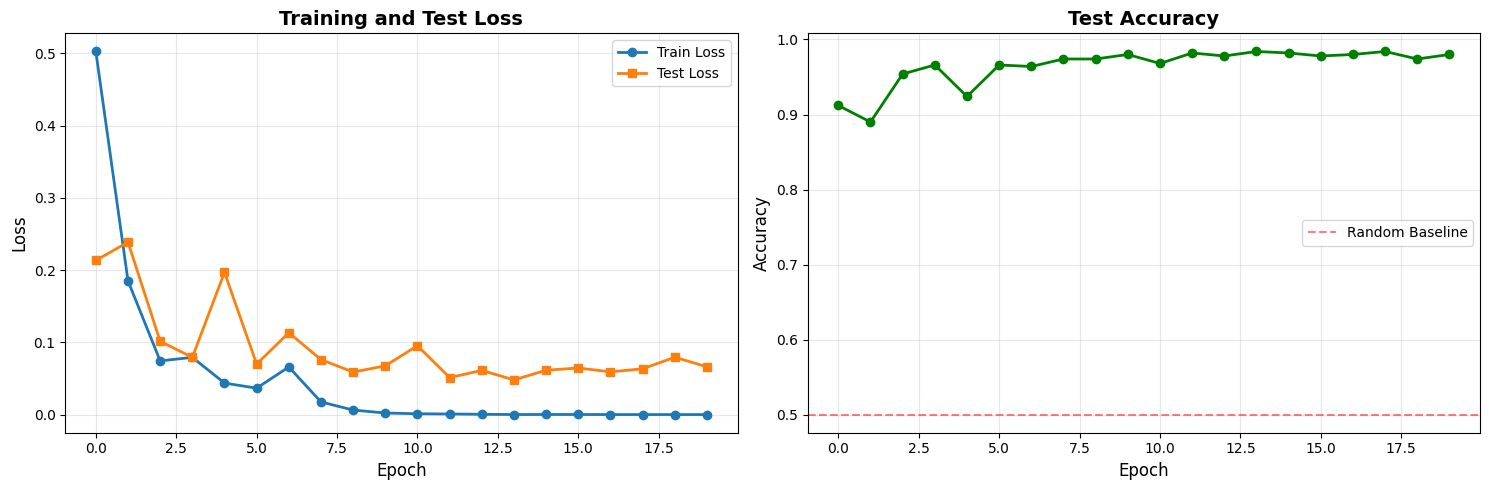


Best Test Accuracy: 0.9840
Final Test Accuracy: 0.9800


In [9]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, marker='o', label='Train Loss', linewidth=2)
ax1.plot(test_losses, marker='s', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(test_accuracies, marker='o', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.5, color='r', linestyle='--', label='Random Baseline', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nBest Test Accuracy: {max(test_accuracies):.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

## Analyze Predictions

In [10]:
# Get predictions on test set
X_tensor = Tensor(X_test[:100].astype(np.float32))
logits = model(X_tensor)
predictions = np.argmax(logits.data, axis=1)
true_labels = y_test[:100]

# Analyze predictions
correct = predictions == true_labels
accuracy = correct.sum() / len(correct)

print("Prediction Analysis (first 100 samples):")
print(f"Accuracy: {accuracy:.2%}")
print(f"Correct: {correct.sum()}/{len(correct)}")

# Show some examples
print("\nSample Predictions:")
print("-" * 60)
print(f"{'True Label':<15} {'Predicted':<15} {'Confidence':<15} {'Correct'}")
print("-" * 60)

for i in range(20):
    true_label = 'Positive' if true_labels[i] == 1 else 'Negative'
    pred_label = 'Positive' if predictions[i] == 1 else 'Negative'
    
    # Get confidence (softmax probability)
    probs = F.softmax(Tensor(logits.data[i:i+1]), axis=1)
    confidence = probs.data[0, predictions[i]]
    
    is_correct = '✓' if correct[i] else '✗'
    
    print(f"{true_label:<15} {pred_label:<15} {confidence:<15.3f} {is_correct}")

Prediction Analysis (first 100 samples):
Accuracy: 98.00%
Correct: 98/100

Sample Predictions:
------------------------------------------------------------
True Label      Predicted       Confidence      Correct
------------------------------------------------------------
Positive        Positive        1.000           ✓
Positive        Positive        1.000           ✓
Positive        Positive        0.989           ✓
Negative        Negative        1.000           ✓
Negative        Negative        1.000           ✓
Positive        Positive        1.000           ✓
Positive        Positive        1.000           ✓
Positive        Positive        1.000           ✓
Positive        Positive        1.000           ✓
Positive        Positive        1.000           ✓
Negative        Negative        1.000           ✓
Negative        Negative        1.000           ✓
Negative        Negative        1.000           ✓
Positive        Positive        0.991           ✓
Positive        Positive   

## Confusion Matrix

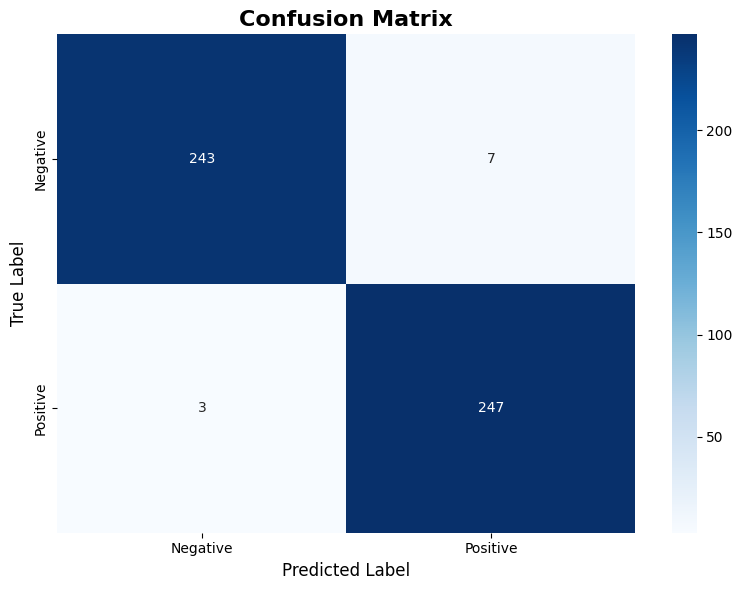


Performance Metrics:
Accuracy:  0.9800
Precision: 0.9724
Recall:    0.9880
F1 Score:  0.9802


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
all_predictions = []
batch_size = 32
for i in range(0, len(X_test), batch_size):
    X_batch = X_test[i:i+batch_size]
    X_tensor = Tensor(X_batch.astype(np.float32))
    logits = model(X_tensor)
    preds = np.argmax(logits.data, axis=1)
    all_predictions.extend(preds)

# Compute confusion matrix
cm = confusion_matrix(y_test, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\nPerformance Metrics:")
print("="*40)
print(f"Accuracy:  {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

## Summary

This notebook demonstrates:
1. **Multi-Head Attention** with proper **Query, Key, Value** matrices
2. **Transformer blocks** with self-attention mechanism
3. **Sequence classification** using attention
4. **Positional encoding** for sequence ordering
5. Training with **Adam optimizer** and **learning rate scheduling**
6. **Memory leak prevention** with computation graph clearing

### Attention Mechanism:
The model uses proper scaled dot-product attention:
- **Query (Q)**: Linear projection of input for "what am I looking for?"
- **Key (K)**: Linear projection of input for "what do I contain?"
- **Value (V)**: Linear projection of input for "what information do I have?"
- **Attention scores**: `softmax(Q @ K^T / sqrt(d_k))`
- **Output**: `Attention @ V`